In [1]:
%pylab inline

from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt

import numpy as np
print(np.__version__)

import tensorflow as tf
print(tf.__version__)

#from tensorflow import keras

import pandas as pd
from sklearn import model_selection

Populating the interactive namespace from numpy and matplotlib
1.16.2
1.13.1


# Load data, split into train and test sets, rescale pixel values

In [64]:
labeled_images = pd.read_csv('train.csv')
images = labeled_images.drop('label', axis=1).values
labels = labeled_images['label'].values

In [65]:
train_images, test_images, train_labels, test_labels = model_selection.train_test_split(
    images, labels, test_size=0.1, random_state=0)

In [66]:
train_images = train_images.reshape((len(train_images), 28, 28, 1))
test_images = test_images.reshape((len(test_images), 28, 28, 1))

print(train_images.shape, test_images.shape)
print(train_images.min(), train_images.max())

(37800, 28, 28, 1) (4200, 28, 28, 1)
0 255


In [67]:
# Rescale pixel intensities from [0, 2**8-1] to [0, 1]
train_images = train_images/255.0
test_images = test_images/255.0

In [68]:
# Cut down on total training size for now
# ntrain = 5000
ntrain = -1
train_images = train_images[:ntrain]
train_labels = train_labels[:ntrain]

# Plot training set examples

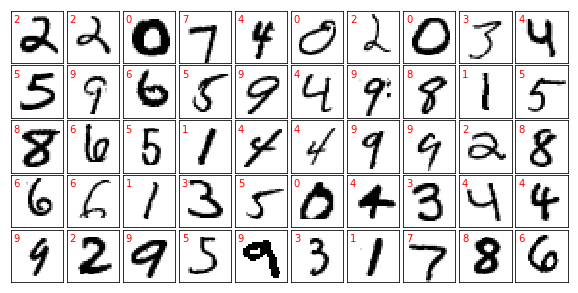

In [243]:
fig = plt.figure(figsize=(10, 5))
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.imshow(train_images[i, :, :, 0], cmap=plt.cm.binary)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(1, 6, train_labels[i], color='r')
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# Neural network designs

In [70]:
def generate_fully_connected_model(units=128, dropout_rate=0.6):
    """1 fully connected hidden layer.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(units, activation=tf.nn.relu),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    return model

In [71]:
def generate_cnn_model(filters1=32, filters2=64, fc_units=1024, dropout_rate=0.4):
    """2 CNN layers each with max pooling, 1 fully connected layer.
    """
    model = tf.keras.Sequential()
    
    # CNN layer 1
    model.add(tf.keras.layers.Conv2D(
        filters=filters1, kernel_size=(5, 5), 
        padding='same', activation='relu', input_shape=(28, 28, 1))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # CNN layer 2
    model.add(tf.keras.layers.Conv2D(
        filters=filters2, kernel_size=(5, 5), 
        padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Fully connected layer with dropout
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(fc_units, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return model

# Choose NN design and train it

In [72]:
#model = generate_fully_connected_model(units=128, dropout_rate=0.9)

model = generate_cnn_model(filters1=32, filters2=64, fc_units=1024, dropout_rate=0.4)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_69 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_138 (Dense)            (None, 1024)              3212288   
_________________________________________________________________
dropout_69 (Dropout)         (None, 1024)              0         
__________

In [73]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=20)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

Epoch 1/20
37799/37799 [==============================] - 84s 2ms/sample - loss: 0.1357 - acc: 0.9575
Epoch 2/20
37799/37799 [==============================] - 85s 2ms/sample - loss: 0.0486 - acc: 0.9847
Epoch 3/20
37799/37799 [==============================] - 86s 2ms/sample - loss: 0.0325 - acc: 0.9899
Epoch 4/20
37799/37799 [==============================] - 88s 2ms/sample - loss: 0.0238 - acc: 0.9927
Epoch 5/20
37799/37799 [==============================] - 88s 2ms/sample - loss: 0.0212 - acc: 0.9929
Epoch 6/20
37799/37799 [==============================] - 89s 2ms/sample - loss: 0.0178 - acc: 0.9944
Epoch 7/20
37799/37799 [==============================] - 90s 2ms/sample - loss: 0.0140 - acc: 0.9959
Epoch 8/20
37799/37799 [==============================] - 90s 2ms/sample - loss: 0.0130 - acc: 0.9961
Epoch 9/20
37799/37799 [==============================] - 89s 2ms/sample - loss: 0.0114 - acc: 0.9966
Epoch 10/20
37799/37799 [==============================] - 88s 2ms/sample - loss: 

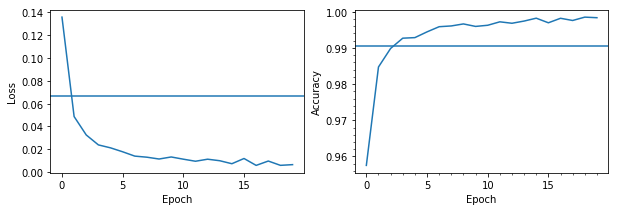

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(history.history['loss'])
ax1.axhline(test_loss)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(history.history['acc'])
ax2.axhline(test_acc)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
#ax2.set_ylim(0, 1)
ax2.minorticks_on()

# Tune hyperparameters

In [48]:
model_data_list = []
for dropout_rate in [0, 0.2, 0.4, 0.6, 0.8, 0.9]:
    model = generate_fully_connected_model(units=128, dropout_rate=dropout_rate)
    
    model.compile(
        optimizer='adam', 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    history = model.fit(train_images, train_labels, epochs=20)
    
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    
    model_data = {'dropout_rate':dropout_rate, 'model':model, 'history':history, 
                  'train_acc':train_acc, 'test_acc':test_acc}
    print(model_data)
    model_data_list.append(model_data)

Epoch 1/20
4999/4999 [==============================] - 1s 220us/sample - loss: 0.7049 - acc: 0.8016
Epoch 2/20
4999/4999 [==============================] - 1s 104us/sample - loss: 0.2989 - acc: 0.9170
Epoch 3/20
4999/4999 [==============================] - 1s 102us/sample - loss: 0.2240 - acc: 0.9396
Epoch 4/20
4999/4999 [==============================] - 1s 105us/sample - loss: 0.1746 - acc: 0.9558
Epoch 5/20
4999/4999 [==============================] - 1s 103us/sample - loss: 0.1417 - acc: 0.9616
Epoch 6/20
4999/4999 [==============================] - 1s 107us/sample - loss: 0.1102 - acc: 0.9714
Epoch 7/20
4999/4999 [==============================] - 1s 113us/sample - loss: 0.0911 - acc: 0.9786
Epoch 8/20
4999/4999 [==============================] - 1s 108us/sample - loss: 0.0697 - acc: 0.9846
Epoch 9/20
4999/4999 [==============================] - 1s 106us/sample - loss: 0.0579 - acc: 0.9886
Epoch 10/20
4999/4999 [==============================] - 1s 106us/sample - loss: 0.0448 - a

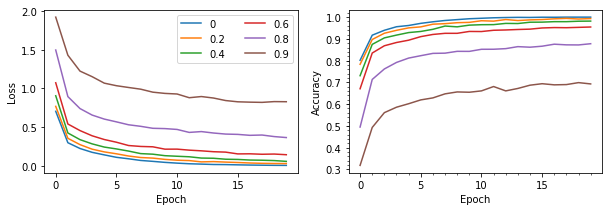

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
for m in model_data_list:
    d = m['dropout_rate']
    history = m['history']
    
    ax1.plot(history.history['loss'], label=d)
    #ax1.axhline(test_loss)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(ncol=2)
    
    ax2.plot(history.history['acc'], label=d)
    #ax2.axhline(test_acc)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    #ax2.set_ylim(0, 1)
    ax2.minorticks_on()

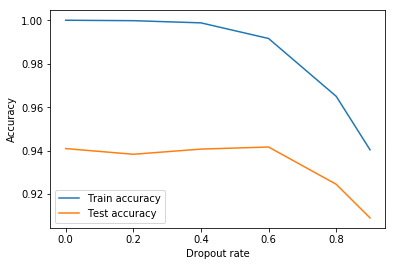

In [49]:
ds = [m['dropout_rate'] for m in model_data_list]
train_acc = [m['train_acc'] for m in model_data_list]
test_acc = [m['test_acc'] for m in model_data_list]

fig, ax = plt.subplots()
ax.plot(ds, train_acc, label='Train accuracy')
ax.plot(ds, test_acc, label='Test accuracy')
ax.set_xlabel('Dropout rate')
ax.set_ylabel('Accuracy')
ax.legend()

# Save model

In [75]:
# https://www.tensorflow.org/tutorials/keras/save_and_restore_models
model.save('my_model.h5')

In [77]:
# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model('my_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_69 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_138 (Dense)            (None, 1024)              3212288   
_________________________________________________________________
dropout_69 (Dropout)         (None, 1024)              0         
__________

In [78]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

4200/4200 [==============================] - 2s 537us/sample - loss: 0.0671 - acc: 0.9905
Test accuracy: 0.9904762


# Make plots

In [150]:
def plot_image_and_prediction(img, model, truth=None, log=False):
    """
    """
    # Make prediction
    # model.predict() expects a batch of images, and returns a list of prob. vectors.
    img_3d = np.expand_dims(img, 0)
    ps = model.predict(img_3d)[0]
    
    # Get maximum probability
    max_i = np.argmax(ps)
    max_p = ps[max_i]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.5, 2.5))
    
    # Plot image
    ax1.imshow(img[:, :, 0], cmap=plt.cm.binary)
    if truth is not None:
        if truth==max_i:
            ax1.set_xlabel(
                'True={:d}, Pred={:d} with p={:.1f}%'.format(truth, max_i, 100*max_p))
        else:
            ax1.set_xlabel(
                'True={:d}, Pred={:d} with p={:.1f}%'.format(truth, max_i, 100*max_p),
                color='r')
    else:
        ax1.set_xlabel('Pred={:d} with p={:.1}%'.format(max_i, 100*max_p))
    
    # Plot probabilities of each number
    xs = np.arange(len(ps))
    barlist = ax2.bar(xs, ps)
    barlist[max_i].set_color('r')
    ax2.set_xticks(xs)
    ax2.set_ylabel('Probability')
    if log==False:
        ax2.set_ylim(0, 1)
    else:
        ax2.set_ylim(1.0e-6, 1.0)
        ax2.set_yscale('log')
        
    fig.tight_layout()

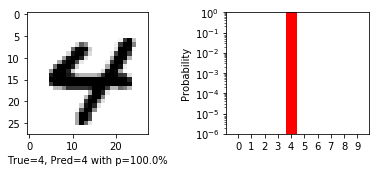

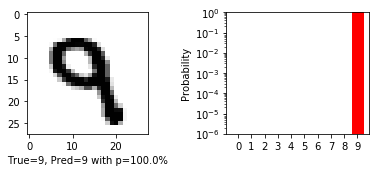

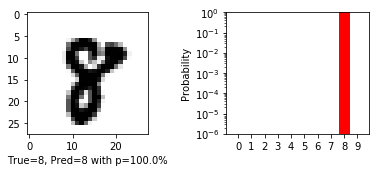

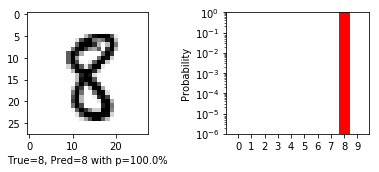

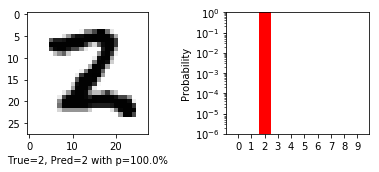

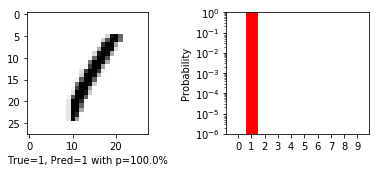

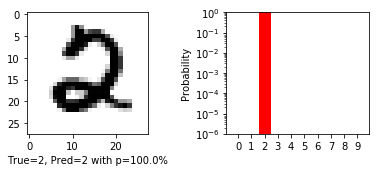

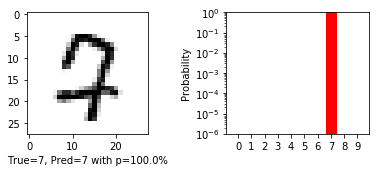

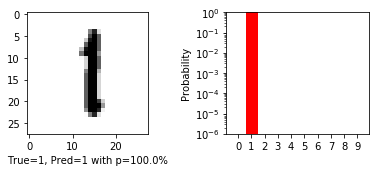

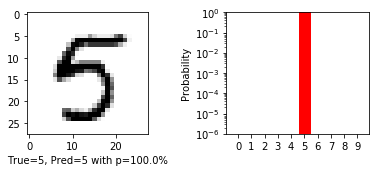

In [152]:
for i in range(1000, 1010):
    img = test_images[i]
    truth = test_labels[i]
    plot_image_and_prediction(img, model, truth=truth, log=True)

# Get confusion matrix

In [155]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classnames=None):
    """Plot the confusion matrix.
    
    Parameters
    ----------
    cm : 2d-array
        Confusion matrix (true value in rows, predicted value in columns)
    classnames : list
        Labels for each class.
    """
    nclasses = len(cm)
    
    fig, ax = plt.subplots(figsize=(1.2*5, 5))
    
    # For imshow,
    # first dimension is top to bottom,
    # second dimension is left to right,
    # just like the confusion matrix.
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    for i in range(nclasses):
        for j in range(nclasses):
            # In imshow() coordinate system, origin of plot is upper left.
            # (First coordinate is x, second is y.)
            # The text() method will take on the coordinate system of imshow.
            # Confusion matrix is row then column (y then x), so switch the two.
            ax.text(j, i, cm[i, j], ha='center', va='center', color='r')
    
    # Second dimension (columns, x) is predicted value
    ax.set_xlabel('Predicted label') 
    # First dimension (rows, y) is true value
    ax.set_ylabel('True label')
    
    # Set tick locations
    ticks = range(nclasses)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    # Set tick names
    if classnames is None:
        classnames=ticks
    ax.set_xticklabels(classnames, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticklabels(classnames)

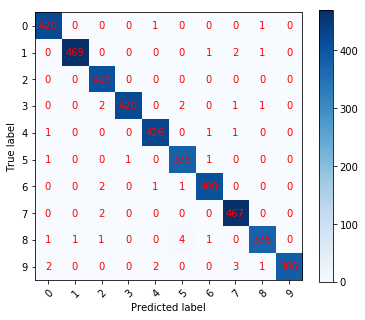

In [156]:
# Get predictions
test_pred_prob = model.predict(test_images)
test_pred = np.argmax(test_pred_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_pred)

plot_confusion_matrix(cm, classnames=None)

# ROC curves

In [244]:
test_pred_prob = model.predict(test_images)

In [274]:
import sklearn.metrics as metrics

i = 0
y_true = test_labels
y_score = test_pred_prob[:, i]
pos_label = i
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=pos_label)

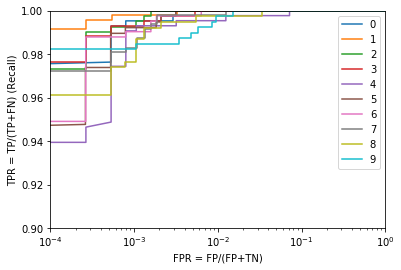

In [282]:
fig, ax = plt.subplots()

for i in range(0, 10):
    y_true = test_labels
    y_score = test_pred_prob[:, i]
    pos_label = i
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=pos_label)

    ax.plot(fpr, tpr, label=str(i))

#ax.plot(np.logspace(-4, 0, 100), np.logspace(-4, 0, 100), ls='--', c='k')
ax.set_xlabel('FPR = FP/(FP+TN)')
ax.set_ylabel('TPR = TP/(TP+FN) (Recall)')
ax.set_xscale('log')
ax.set_xlim(1.0e-4, 1)
ax.set_ylim(0.9, 1)
ax.legend()

# Show images of wrong labels

In [144]:
def get_indices_of_wrong_labels(true_labels, images, model):
    """
    """
    # Get predictions
    pred_prob = model.predict(images)
    pred = np.argmax(pred_prob, axis=1)
    wrong_i = np.where(pred!=true_labels)[0]
    return wrong_i

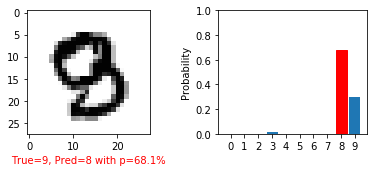

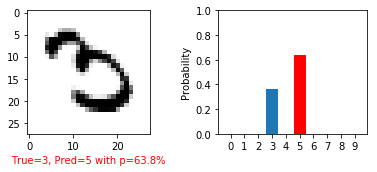

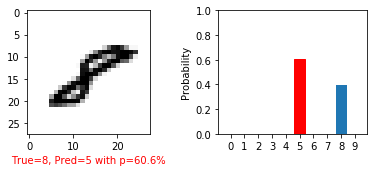

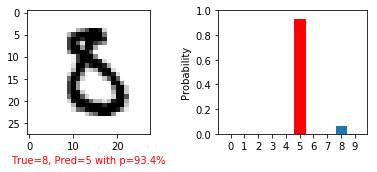

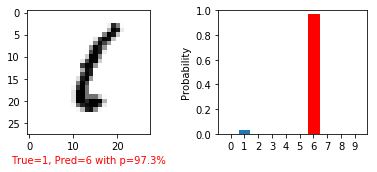

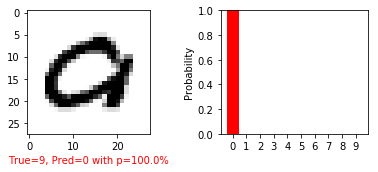

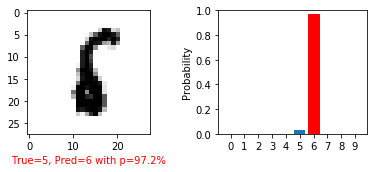

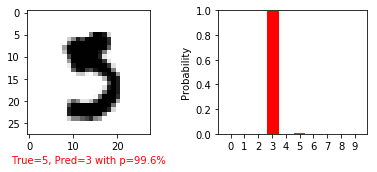

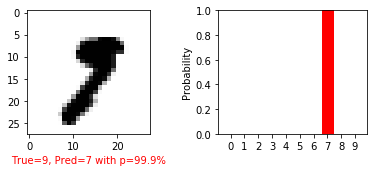

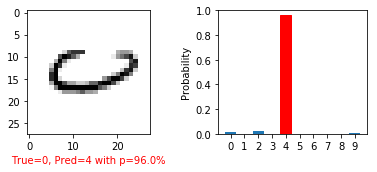

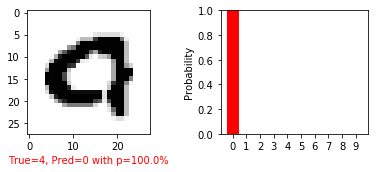

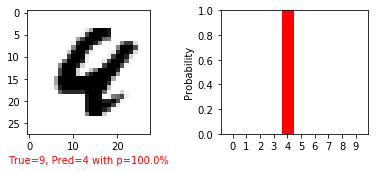

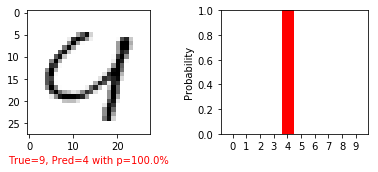

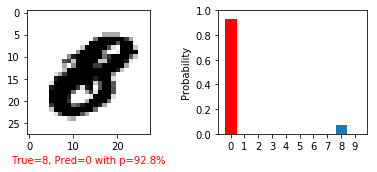

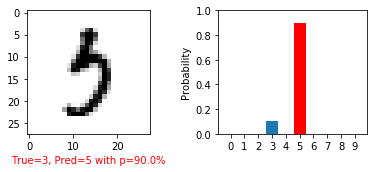

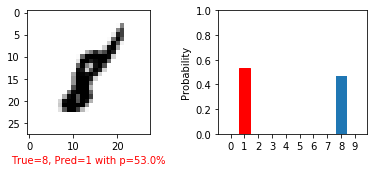

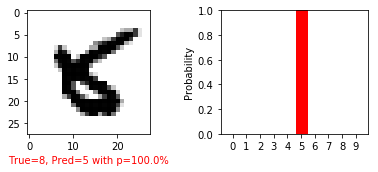

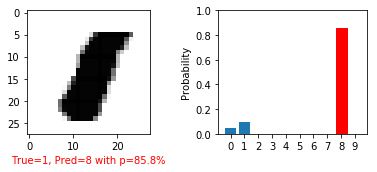

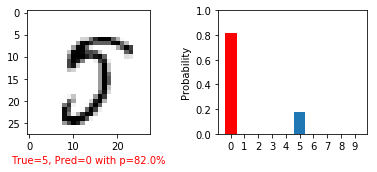

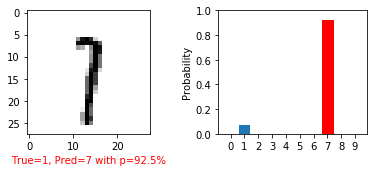

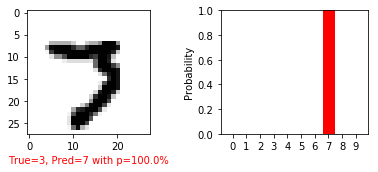

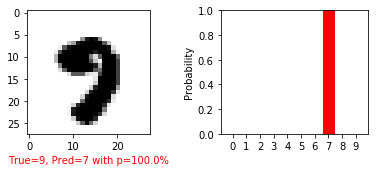

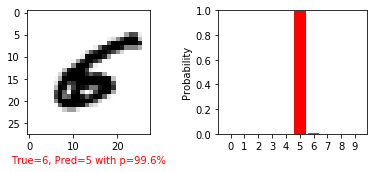

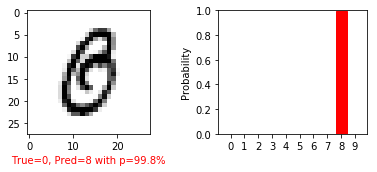

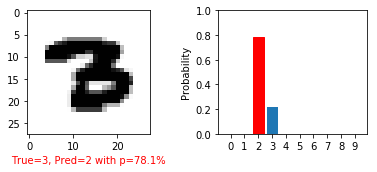

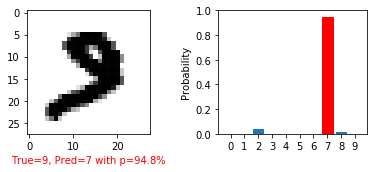

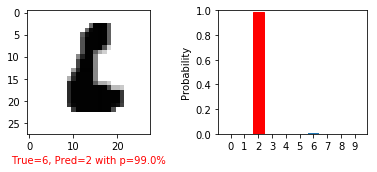

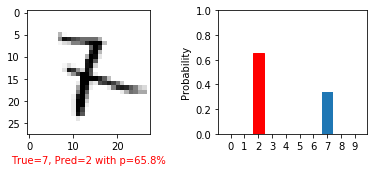

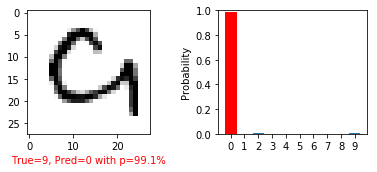

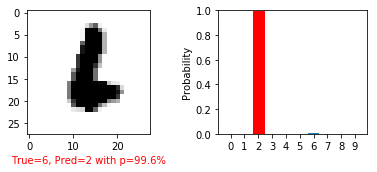

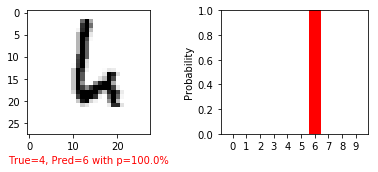

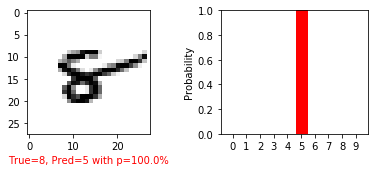

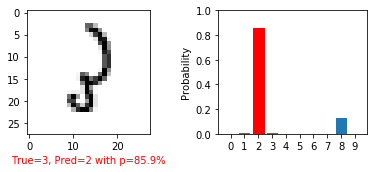

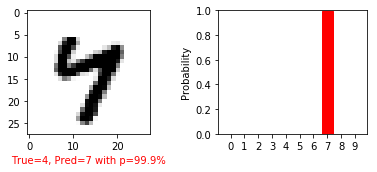

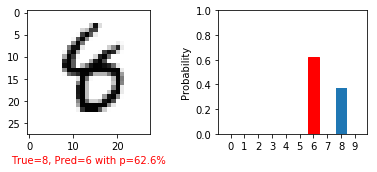

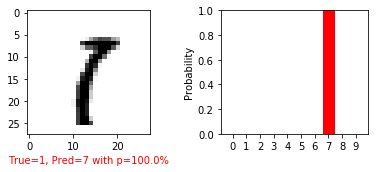

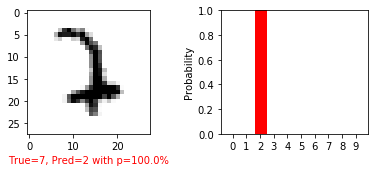

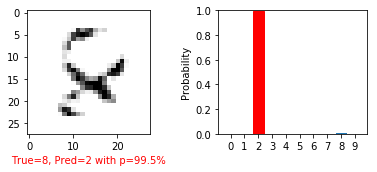

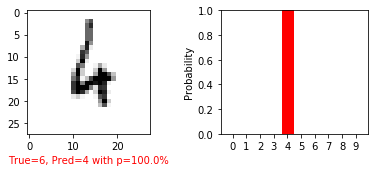

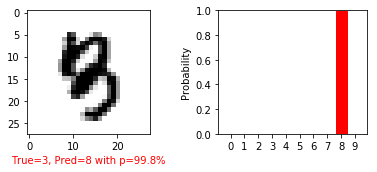

In [153]:
wrong_i = get_indices_of_wrong_labels(test_labels, test_images, model)

for i in wrong_i:
    img = test_images[i]
    truth = test_labels[i]
    plot_image_and_prediction(img, model, truth=truth)

# Plot the filters

In [215]:
def plot_filters(layer, subplotsize=1.0, ncol=10):
    """Take a Conv2D layer, and plot each filter.
    """
    weights = layer.get_weights()[0]

    nfilters = weights.shape[3]
    nrow = nfilters//ncol + 1
    
    fig = plt.figure(figsize=(subplotsize*ncol, subplotsize*nrow))
    
    for i in range(nfilters):
        ax = fig.add_subplot(nrow, ncol, i+1)
        
        filt_img = weights[:, :, 0, i]
        ax.imshow(filt_img, cmap=plt.cm.binary)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

In [221]:
model.layers

In [222]:
model.get_layer(index=0)

In [223]:
model.get_layer(index=2)

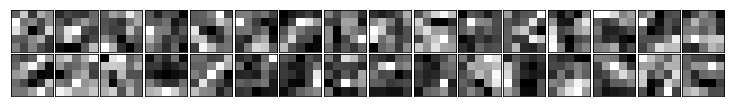

In [233]:
layer = model.get_layer(index=0)
plot_filters(layer, subplotsize=0.8, ncol=16)

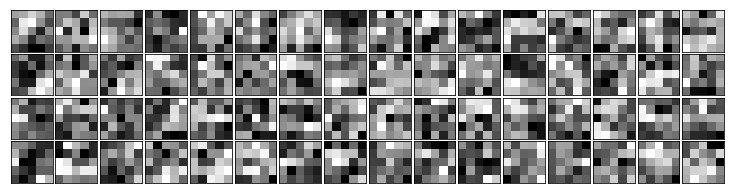

In [232]:
# TODO: Each of the 64 filters is actually 5*5*32 not 5*5. This is not a correct plot.
layer = model.get_layer(index=2)
plot_filters(layer, subplotsize=0.8, ncol=16)